Method1: Misalignment with Next Frame Prediction

In [1]:

import os
import numpy as np
from six.moves import cPickle
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras import backend as K
from keras.models import Model, model_from_json
from keras.layers import Input, Dense, Flatten

from prednet import PredNet
from data_utils import SequenceGenerator
from kitti_settings import *

import time 
# start = time.process_time()
# print("-----beginning time: ", start)

Using TensorFlow backend.


-----beginning time:  7.663408


In [2]:
n_plot = 40
batch_size = 10
nt = 10

weights_file = os.path.join(WEIGHTS_DIR, 'tensorflow_weights/prednet_kitti_weights.hdf5')
json_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_model.json')
test_file = os.path.join(DATA_DIR, 'X_test.hkl')
test_sources = os.path.join(DATA_DIR, 'sources_test.hkl')

# Load trained model
f = open(json_file, 'r')
json_string = f.read()
f.close()


train_model = model_from_json(json_string, custom_objects = {'PredNet': PredNet})
train_model.load_weights(weights_file)




Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
keep_dims is deprecated, use keepdims instead







In [3]:
# Create testing model (to output predictions)
layer_config = train_model.layers[1].get_config()
layer_config['output_mode'] = 'prediction'
data_format = layer_config['data_format'] if 'data_format' in layer_config else layer_config['dim_ordering']
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)
input_shape = list(train_model.layers[0].batch_input_shape[1:])
input_shape[0] = nt
inputs = Input(shape=tuple(input_shape))
predictions = test_prednet(inputs)
test_model = Model(inputs=inputs, outputs=predictions)
# import pdb; pdb.set_trace()
test_generator = SequenceGenerator(test_file, test_sources, nt, sequence_start_mode='unique', data_format=data_format)
X_test = test_generator.create_all()
# batch_size=3  # used to be 10  //manually adddd.


/data_0 b'ndarray' <KeysViewHDF5 ['type']>
/data_0 b"<type 'list'>" <KeysViewHDF5 ['type']>


In [4]:
from PIL import Image
import PIL
import glob

SCENE_SIZE = 10   # pre-trained prednet only do size 10
basewidth = 160
hsize = 128

# load example image
filelist = glob.glob('data/stuttgart_00/*.png')
filelist.sort()
example_img = 'data/stuttgart_00/stuttgart_00_000000_000263_leftImg8bit.png'
img1 = Image.open(example_img)
img1 = img1.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
nparr1 = np.array(img1)


filelist.append(filelist[-1]) #------- should comment this line out if not use the stugard_00 model
print(len(filelist))
filelist = filelist[:int(len(filelist)/SCENE_SIZE)*SCENE_SIZE]   
num_scene = int(len(filelist)/SCENE_SIZE)

np_arr = np.zeros(shape=(num_scene,SCENE_SIZE,3,128,160))

print(np_arr.shape)


for i in range(num_scene):
    #every 10, put 
    for j in range(SCENE_SIZE):
        if i*SCENE_SIZE + j < len(filelist):
            img1 = Image.open(filelist[i*SCENE_SIZE + j])
            img1 = img1.resize((basewidth, hsize), PIL.Image.ANTIALIAS)

            np_arr[i][j] = np.transpose(np.array(img1), (2,0,1))/255

print(np_arr.shape)  


600
(60, 10, 3, 128, 160)
(60, 10, 3, 128, 160)


In [5]:
X_test = np_arr

In [6]:
# Run the model on X_test
X_hat = test_model.predict(X_test, batch_size)
if data_format == 'channels_first':
    X_test = np.transpose(X_test, (0, 1, 3, 4, 2))
    X_hat = np.transpose(X_hat, (0, 1, 3, 4, 2))

(128, 160, 3)


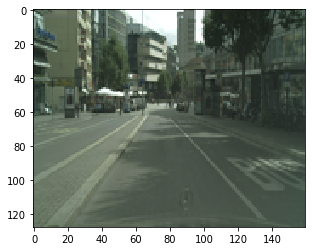

In [7]:

print(X_test[0,3].shape)
%matplotlib inline
import matplotlib.pyplot as plt

# example frame
plt.imshow(X_test[28,7], interpolation='none')


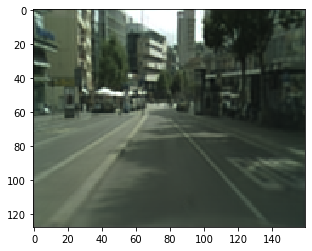

In [8]:
#example predicted frame
plt.imshow((X_hat[28,7]), interpolation='none')

Text(0.5, 1.0, 'Predicted frame MSE and previous frame MSE')

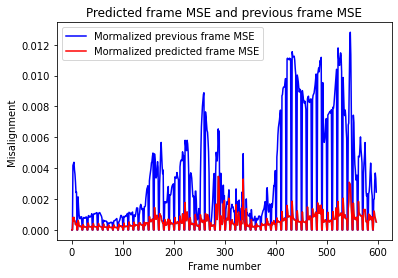

In [25]:
mse_model_per_frame = []
mse_prev_per_frame = []
for i in range(num_scene):
    for j in range(10): # look at all timesteps except the first 2
        if j == 0 or j == 1:
            mse_model_per_frame.append(0) 
            mse_prev_per_frame.append(0)
        else:
            mse_model_per_frame.append(np.mean((X_test[i, j] - X_hat[i, j])**2))
            mse_prev_per_frame.append(np.mean((X_test[i, j-1] - X_test[i, j])**2))

# ------comment this out if not for stugard_00
mse_prev_per_frame = mse_prev_per_frame[:-2] 
mse_model_per_frame = mse_model_per_frame[:-2]

time = [x for x in range(len(mse_prev_per_frame))]
plt.plot(time, mse_model_per_frame)
plt.xlabel('Frame number')
plt.ylabel('Misalignment')
plt.plot(time, mse_prev_per_frame, 'b-', label='Mormalized previous frame MSE')
plt.plot(time, mse_model_per_frame, 'r-', label='Mormalized predicted frame MSE')  
plt.legend(loc="best")
plt.title('Predicted frame MSE and previous frame MSE')



Text(0.5, 1.0, 'Mormalized Difference between predicted frame MSE and previous frame MSE')

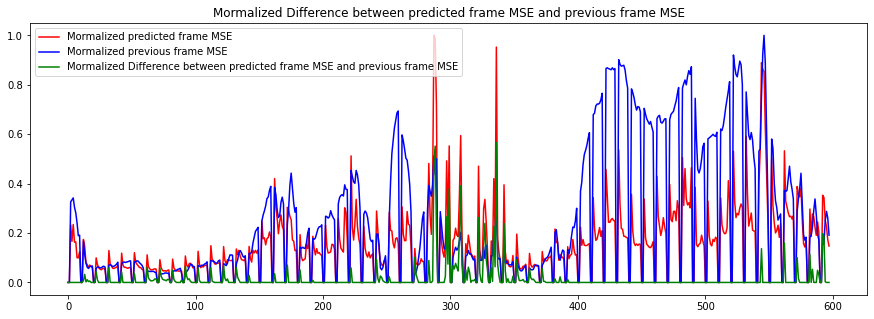

In [23]:
mse_model_per_frame_min = min(mse_model_per_frame)
mse_model_per_frame_max = max(mse_model_per_frame)
mse_prev_per_frame_min = min(mse_prev_per_frame)
mse_prev_per_frame_max= max(mse_prev_per_frame)
mormalized_mse_model_per_frame = [(num-mse_model_per_frame_min)/(mse_model_per_frame_max-mse_model_per_frame_min) for num in mse_model_per_frame]
mormalized_mse_prev_per_frame = [(num-mse_prev_per_frame_min)/(mse_prev_per_frame_max-mse_prev_per_frame_min) for num in mse_prev_per_frame]
mormalized_difference = [max(0, mormalized_mse_model_per_frame[i]-mormalized_mse_prev_per_frame[i]) for i in range(len(mse_prev_per_frame))]

plt.figure(figsize=(15, 5))
plt.plot(time, mormalized_mse_model_per_frame, 'r-', label='Mormalized predicted frame MSE')  
plt.plot(time, mormalized_mse_prev_per_frame, 'b-', label='Mormalized previous frame MSE')
plt.plot(time, mormalized_difference, 'g-', label='Mormalized Difference between predicted frame MSE and previous frame MSE')
plt.legend(loc="best")

plt.title('Mormalized Difference between predicted frame MSE and previous frame MSE (Not a good indication of where the annomolies are)')


# for i in range(len(mormalized_difference)):
#     if mormalized_difference[i] > 0.4:
#         print(i)

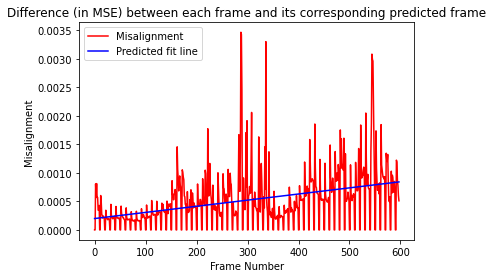

In [26]:
from sklearn.linear_model import LinearRegression
x = np.array(time).reshape((-1, 1))
y = np.array(mse_model_per_frame)
model = LinearRegression().fit(x, y)

y_pred = model.predict(x)

plt.plot(x, y, 'r-', label='Misalignment')  
plt.plot(x, y_pred, 'b-', label='Predicted fit line')
plt.legend(loc="best")
plt.title('Difference (in MSE) between each frame and its corresponding predicted frame')
plt.xlabel('Frame Number')
plt.ylabel('Misalignment')

plt.show()


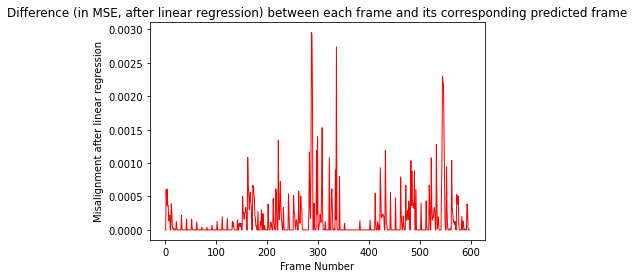

In [27]:
# this method is the best indication of where the annomolies are

i = 0
for i in range(len(y)):
    value = y[i]
    if value < y_pred[i]:
        y[i] = 0
    else:
        y[i] = value - y_pred[i]
        i += 1 
#     if y[i] > 0.002:
#         print(i)
    
plt.plot(x, y,  color='red', linewidth=1)
plt.title('Difference (in MSE, after linear regression) between each frame and its corresponding predicted frame')
plt.xlabel('Frame Number')
plt.ylabel('Misalignment after linear regression')

plt.show()

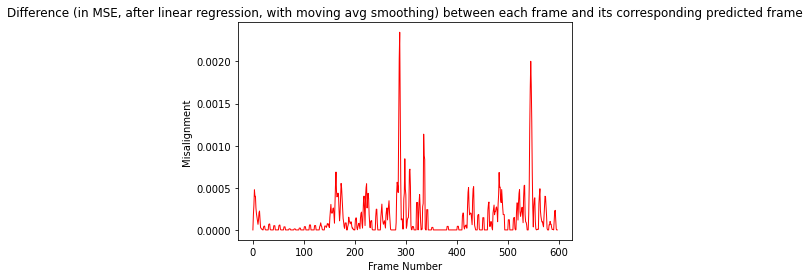

In [28]:

y_moving_avg = [y[0]]+[ 0.3*y[i-1]+0.3*y[i]+0.3*y[i+1] for i in range(1,len(y)-1)]+[y[-1]]
plt.plot(x, y_moving_avg,  color='red', linewidth=1)
plt.title('Difference (in MSE, after linear regression, with moving avg smoothing) between each frame and its corresponding predicted frame')
plt.xlabel('Frame Number')
plt.ylabel('Misalignment')

plt.show()

In [14]:
# Compare MSE of PredNet predictions vs. using last frame.  Write results to prediction_scores.txt
mse_model = np.mean( (X_test[:, 1:] - X_hat[:, 1:])**2 )  # look at all timesteps except the first
mse_prev = np.mean( (X_test[:, :-1] - X_test[:, 1:])**2 )
if not os.path.exists(RESULTS_SAVE_DIR): os.mkdir(RESULTS_SAVE_DIR)
f = open(RESULTS_SAVE_DIR + 'prediction_scores.txt', 'w')
f.write("Model MSE: %f\n" % mse_model)
f.write("Previous Frame MSE: %f" % mse_prev)
f.close()

In [15]:
# Plot some predictions
aspect_ratio = float(X_hat.shape[2]) / X_hat.shape[3]
plt.figure(figsize = (nt, 2*aspect_ratio))
gs = gridspec.GridSpec(2, nt)
gs.update(wspace=0., hspace=0.)
plot_save_dir = os.path.join(RESULTS_SAVE_DIR, 'prediction_plots/')
if not os.path.exists(plot_save_dir): os.mkdir(plot_save_dir)
plot_idx = np.random.permutation(X_test.shape[0])[:n_plot]
for i in plot_idx:
    for t in range(nt):
        plt.subplot(gs[t])
        plt.imshow(X_test[i,t], interpolation='none')
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Actual', fontsize=10)

        plt.subplot(gs[t + nt])
        plt.imshow(X_hat[i,t], interpolation='none')
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Predicted', fontsize=10)

    plt.savefig(plot_save_dir +  'plot_' + str(i) + '.png')
    plt.clf()
# print("-----total time spend: ", time.process_time() - start)


<Figure size 720x115.2 with 0 Axes>